# 2.10 Dimensionality Reduction

Ideally, one would not need to extract or select features in the input data. However, reducing the dimensionality as a separate pre-processing step may be advantageous:

1. The complexity of the algorithm depends on the number of input dimensions and size of the data.
2. If some features are unecessary, not extracting them saves computing time
3. Simpler models are more robust on small datasets
4. Fewer features lead to a better understanding of the data.
5. Visualization is easier in fewer dimensions.


Feature *selection* finds the dimensions that explain the data without loss of information and ends with a smaller dimensionality of the input data. A *forward selection* approach starts with one variable that decreases the error the most and adds one by one. A *backward selection* starts with all variables and removes them one by one.

Feature *extraction* finds a new set of dimensions as a combination of the original dimensions. They can be supervised or unsupervised depending on the output information. Examples are **Principal Component Analysis**, **Independent Component Analysis** **Linear Discriminant Analysis**


## Principal Component Analysis

PCA is an unsupervised learning method that finds the mapping from the input to a lower dimensional space with minimum loss of information. First, we will download again our GPS time series from Oregon.

In [90]:
# Import useful modules
import requests, zipfile, io, gzip, glob, os
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as ln
import pandas as pd
import matplotlib
from matplotlib import cm
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn import datasets
import sklearn

## 2.10.1 Feature selection via parameter exploration

In [32]:
# Heatmap functions
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

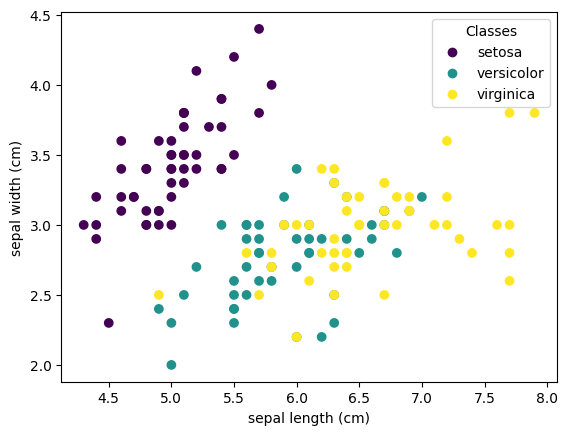

In [42]:
# Let's load in the iris dataset
iris = datasets.load_iris()

# Convert iris to a pandas dataframe...
irisDF = pd.DataFrame(data=iris.data,  
                  columns=iris.feature_names)

# Now, plot up sepal length vs width, color-coded by target (or species)

scatter = plt.scatter(irisDF['sepal length (cm)'], irisDF['sepal width (cm)'], c=iris.target)
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.legend(scatter.legend_elements()[0], iris.target_names, title="Classes")

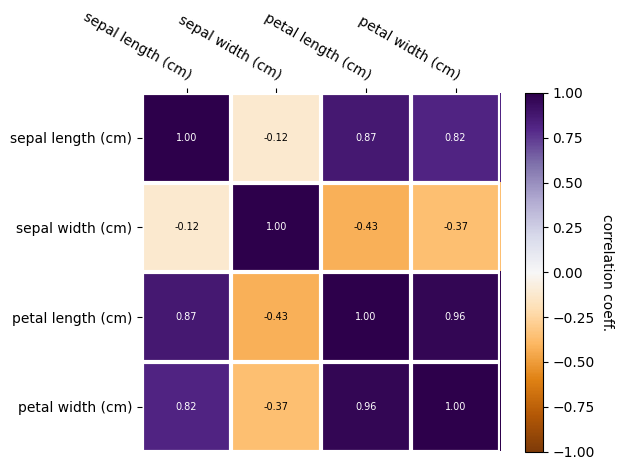

In [43]:
# Now, how might we reduce these dimensions? 
# One way is by looking at how variables are correlated
# Calculate the correlation coefficients for all variables
allCorr = irisDF.corr()

im, _ = heatmap(allCorr, irisDF.head(), irisDF.head(),
                cmap="PuOr", vmin=-1, vmax=1,
                cbarlabel="correlation coeff.")

annotate_heatmap(im, size=7)

plt.tight_layout()
plt.show()

Now, which dimensions might we remove?

## 2.10.2 Feature extraction via PCA

Principal Component Analysis (**PCA**) identifies the axis that accounts for the largest amount of variance in the data. 

Let: $\mathbf{Y} = \mathbf{y}_1,\cdots,\mathbf{y}_n $ be the data, measured $n$ times over multiple fields of measurements (the length of $\mathbf{y})$. 

Each **column** of $\mathbf{Y}$ represents a unique observation. Each **row** of $ \mathbf{Y} $ represents a single parameter.  

To undertake PCA, we will

1. Center and standardize the data by subtracting the mean of each row of $\mathbf{Y} $.
2. Calculate the covariance matrix of the de-meaned data $\mathbf{C}  =  \frac{1}{n-1} \mathbf{Y}^{\ast}\mathbf{Y}$. By definition, the covariance matrix is positive symmetric, and thus can be diagonalized.
3. Calculate the *Singular Value Decomposition (SVD)* of the covariance matrix $\mathbf{C} $. 

As the name implies, SVD decomposes the data covariance matrix $\mathbf{C} $ into 3 terms:

$\mathbf{X} = \mathbf{U} \Sigma \mathbf{V}^T ,$

where $\mathbf{V}^T$ contains the eigenvectors, or principal components. 

Principal components are normalized, centered around zero.

The *1st principal component* eigenvector has the highest eigenvalue in the direction that has the highest variance.

To demonstrate the application of PCA, we will start with some toy data: a two-dimensional (2D) point cloud made up of 10,000 observations, each with two parameters.

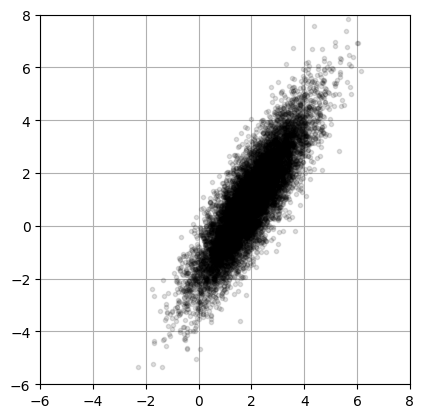

In [4]:
# Generating the toy data
xC = np.array([2, 1])      # Center of data (mean)
sig = np.array([2, 0.5])   # Principal axes
theta = np.pi/3            # Rotate cloud by pi/3
R = np.array([[np.cos(theta), -np.sin(theta)],     # Rotation matrix
              [np.sin(theta), np.cos(theta)]])
nPoints = 10000            # Create 10,000 points

# create the cloud of points by multiplying (np.matmul is also called by @)
X = R @ np.diag(sig) @ np.random.randn(2,nPoints) + np.diag(xC) @ np.ones((2,nPoints))
# plot the data
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(X[0,:],X[1,:], '.', color='k', alpha=0.125)
ax1.grid()
plt.xlim((-6, 8))
plt.ylim((-6,8))
ax1.set_aspect('equal')

### *Step one: subtract the mean*

In [5]:
## Remove the mean of the data
Xavg = np.mean(X, axis=1)                 # Compute mean
B = X - np.tile(Xavg,(nPoints,1)).T       # Mean-subtracted data

### *Step two: Determine the SVD of the covariance matrix*

In [66]:
# Find principal components (SVD): 
# use the option full_matrices =0 will calculate the covariance of B
# Here, we transpose B so that each observation is on a row

U, S, VT = np.linalg.svd(B.T,full_matrices=0)

[[ 0.42469643  0.747179    0.85328813 ...  0.88246352 -1.884191
  -1.32403592]
 [-0.18730514  0.80047482  1.11341706 ... -0.09048239 -2.95497644
  -0.18146037]]
[[ 0.42469643 -0.18730514]
 [ 0.747179    0.80047482]
 [ 0.85328813  1.11341706]
 ...
 [ 0.88246352 -0.09048239]
 [-1.884191   -2.95497644]
 [-1.32403592 -0.18146037]]


### *Step three: explore the outcomes*

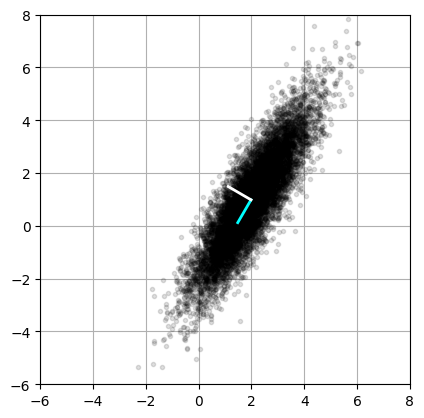

In [65]:

fig = plt.figure()
ax2 = fig.add_subplot(111)
ax2.plot(X[0,:],X[1,:], '.', color='k', alpha=0.125)   # Plot data to overlay PCA
ax2.grid()
plt.xlim((-6, 8))
plt.ylim((-6,8))
ax2.set_aspect('equal')

# Plot eigenvectors VT[:,0] and VT[:,1]
ax2.plot(np.array([Xavg[0], Xavg[0]+VT[0,0]]),
         np.array([Xavg[1], Xavg[1]+VT[1,0]]),'-',color='cyan',linewidth=2)
ax2.plot(np.array([Xavg[0], Xavg[0]+VT[0,1]]),
         np.array([Xavg[1], Xavg[1]+VT[1,1]]),'-',color='white',linewidth=2)

plt.show()

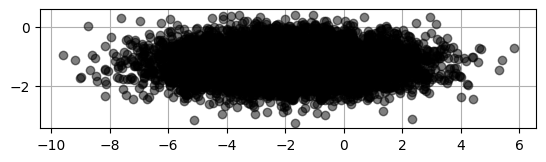

In [70]:
# Let us project the original data
# Projecting the data onto the right singular vectors

projected = X.T.dot(VT.T)

plt.scatter(projected[:,0], projected[:,1], c='k', alpha=0.5)
ax = plt.gca()
ax.set_axisbelow(True)
ax.grid()
ax.set_aspect('equal')


## 2.10.3 PCA on 3D data.

Now let's work on the 3D component of the surface motions recorded at a GPS data. 

Our 3 parameters are displacements in: East, North, and Vertical. These measurements are made daily for many years.

In [72]:
# Download data and save into a pandas.
sta="P395"
file_url="http://geodesy.unr.edu/gps_timeseries/tenv/IGS14/"+ sta + ".tenv"
r = requests.get(file_url).text.splitlines()  # download, read text, split lines into a list
ue=[];un=[];uv=[];se=[];sn=[];sv=[];date=[];date_year=[];df=[]
for iday in r:  # this loops through the days of data
    crap=iday.split()
    if len(crap)<10:
      continue
    date.append((crap[1]))
    date_year.append(float(crap[2]))
    ue.append(float(crap[6])*1000)
    un.append(float(crap[7])*1000)
    uv.append(float(crap[8])*1000)
# Extract the three data dimensions
E = np.asarray(ue)# East component
N = np.asarray(un)# North component
U = np.asarray(uv)# Vertical component

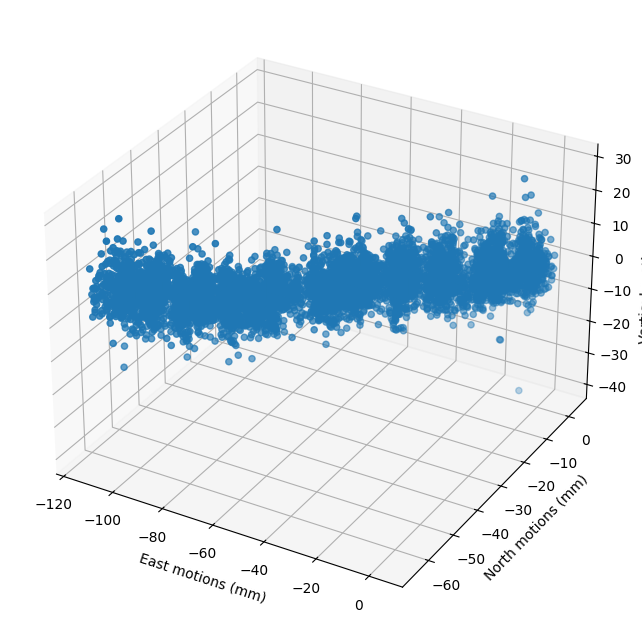

In [73]:
# plot the data
fig=plt.figure(figsize=(11,8))
ax=fig.add_subplot(projection='3d')
ax.scatter(E,N,U);ax.grid(True)
ax.set_xlabel('East motions (mm)')
ax.set_ylabel('North motions (mm)')
ax.set_zlabel('Vertical motions (mm)')
plt.show()

In [91]:
# Let's organize our GPS data in a matrix
X = np.vstack([E,N,U])
print(U.shape)
print(X.shape)
nPoints=U.shape[0]
{
    "tags": [
        "hide-output"
    ]
}

(6341,)
(3, 6341)


{'tags': ['hide-output']}

In [92]:
## Remove the mean of the data
Xavg = np.mean(X,axis=1)                  # Compute mean
B = X - np.tile(Xavg,(nPoints,1)).T       # Mean-subtracted data

[36.90832086  5.4954325   1.81382108]


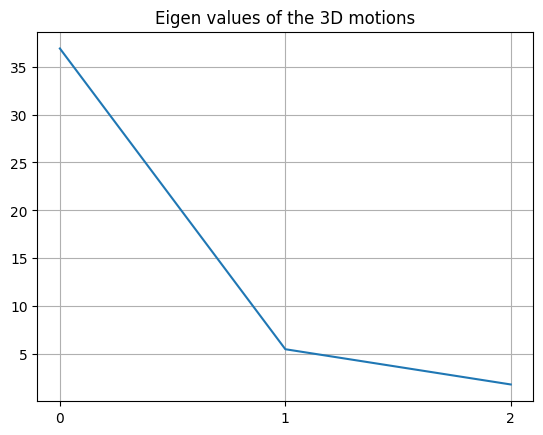

In [93]:
# Find principal components (SVD): 
# use the option full_matrices =0 will calculate the covariance of B
U, S, VT = np.linalg.svd(B.T/np.sqrt(nPoints),full_matrices=0)
print(S)
plt.plot(S);plt.grid(True)
plt.xticks(range(0,3));plt.title('Eigen values of the 3D motions');plt.show()

There are 3 components of motion, but the majority of the motion is explained in 1 direction.

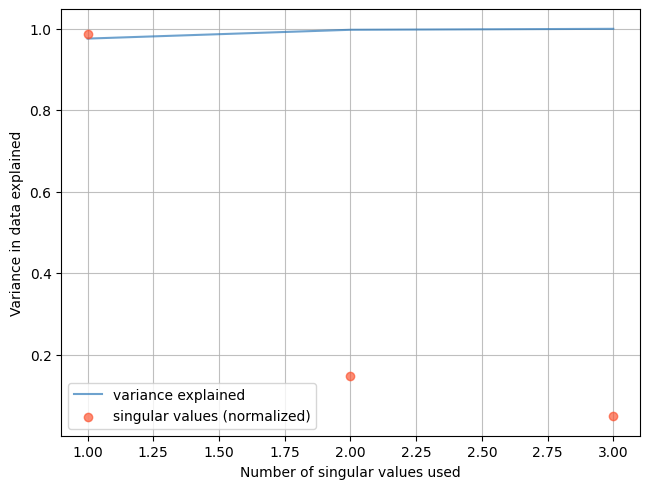

In [98]:
numSV = np.arange(1, S.size+1)

cumulativeVarianceExplained = [np.sum(np.square(S[0:n])) / np.sum(np.square(S)) for n in numSV]

plt.plot(numSV,
         cumulativeVarianceExplained,
         color='#2171b5',
         label='variance explained',
         alpha=0.65,
         zorder=1000)

plt.scatter(numSV,
            sklearn.preprocessing.normalize(S.reshape((1,-1))),
            color='#fc4e2a',
            label='singular values (normalized)',
            alpha=0.65,
            zorder=1000)

plt.grid(alpha=0.8, zorder=1)
plt.tight_layout()
ax = plt.gca()
ax.set_xlabel(r'Number of singular values used')
ax.set_ylabel('Variance in data explained')
plt.legend()

The first eigenvector that explains most of the variance is oriented in the East direction. 

Now let us use the ``sklearn`` package. The model ``PCA`` deals with the data transformation (removing mean and standardizing), calculate the covariance, and the SVD.

**WARNING:** Numpy and sklean do not organize the data in the same dimension. 
* Using sklearn, organize the data for each field as a column.
* Using numpy, organize the data for each field as a row.


In [99]:
from sklearn.decomposition import PCA # this is the SKLEAN model
pca=PCA(n_components=3).fit(X.transpose())# retain all 3 components
print(pca)

PCA(n_components=3)


In [100]:
# The 3 PCs
print(pca.components_)

[[-0.88070032 -0.47256154  0.03244272]
 [-0.0475276   0.02001436 -0.99866939]
 [-0.47128343  0.88107038  0.04008636]]


In [101]:
# The 3 PCs' explained variance
print(pca.explained_variance_)

[1362.43901058   30.20454172    3.29046581]


Now you see that most of the variance is explained by the first PC. What azimuth is the direction of the first PC?

In [102]:
import math
azimuth=math.degrees(math.atan2(pca.components_[0][0],pca.components_[0][1]))
if azimuth <0:azimuth+=360
print("direction of the plate ",azimuth," degrees from North")

direction of the plate  241.7831169485096  degrees from North


[0.97600531 0.02163751 0.00235718]


Text(0.5, 1.0, 'Cumulative PCs')

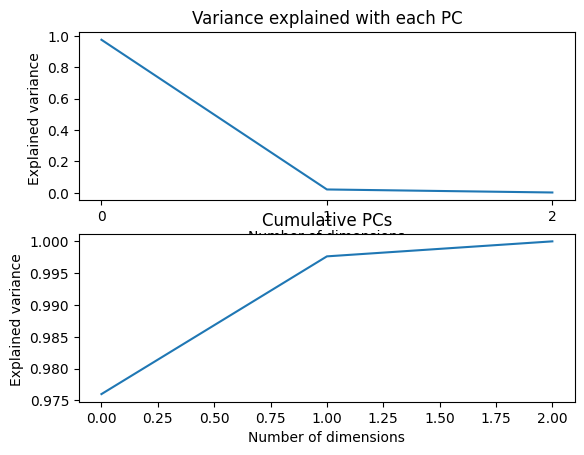

In [105]:
# The 3 PCs' explained variance ratio: how much of the variance is explained by each component
print(pca.explained_variance_ratio_)
fig,ax=plt.subplots(2,1)
ax[0].plot(pca.explained_variance_ratio_);ax[0].set_xticks(range(0,3))
ax[0].set_xlabel('Number of dimensions')
ax[0].set_ylabel('Explained variance ')
ax[0].set_title('Variance explained with each PC')
ax[1].plot(np.cumsum(pca.explained_variance_ratio_))
ax[1].set_xlabel('Number of dimensions')
ax[1].set_ylabel('Explained variance ')
ax[1].set_title('Cumulative PCs')

Now we see that 97% of the variance is explained by the first PC. We can reduce the dimension of our system by only working with a single dimension. Another way to choose the number of dimensions is to select the minimum of PCs that would explain 95% of the variance.

In [108]:
d = np.argmax(np.cumsum(pca.explained_variance_ratio_)>=0.95) +1
print("Minimum dimension size to explain 95% of the variance: ",d)

minimum dimension size to explain 95% of the variance:  1


In [109]:
pca = PCA(n_components=d).fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (3, 6341)
transformed shape: (3, 1)


Inverse Transform back to the original data, but with only the first PC

(3, 6341)


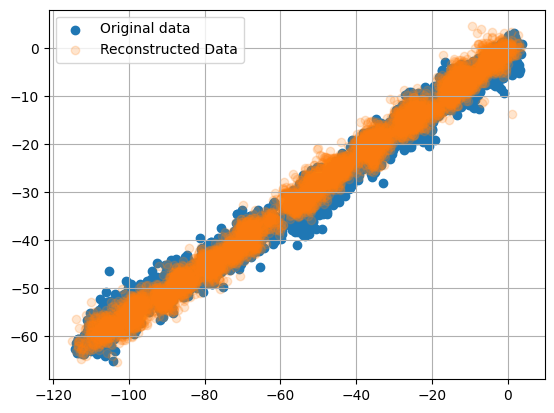

[ 1.69  -0.668 -6.747]
[ 2.14194643 -1.44586065 -6.42108578]


In [115]:
# Find the azimuth of the displacement vector
X_new = pca.inverse_transform(X_pca)
print(X_new.shape)
plt.scatter(X[0,:], X[1,:], alpha=1)
plt.scatter(X_new[0,:], X_new[1,:], alpha=0.2)
plt.legend(['Original data','Reconstructed Data'])
plt.grid(True)
plt.show()

*SVD* can be computationally intensive for larger dimensions.

It is recommended to use a **randomized PCA** to approximate the first principal components. Scikit-learn automatically switches to randomized PCA in either the following happens: data size > 500, number of vectors is > 500 and the number of PCs selected is less than 80% of either one.


## Independent Component Analysis

ICA is used to estimate sources given noisy measurements. It is frequently used in Geodesy to isolate contributions from earthquakes and hydrology. 

In [60]:
from scipy import signal
from sklearn.decomposition import FastICA

# Generate sample data
np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

# create 3 source signals
s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal


S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise
S /= S.std(axis=0)  # Standardize data

print(S)



[[ 0.495126    0.07841108 -1.31840023]
 [ 0.64019598  1.34570272 -1.94657351]
 [ 0.28913069  0.9500949  -1.646886  ]
 ...
 [-0.38561943 -0.71624672  1.34043406]
 [-0.50777458 -1.24052539  1.74176784]
 [-0.5550078  -0.90265774 -1.54534953]]


In [61]:
# Mix data
# create 3 signals at 3 receivers:
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations
# Compute ICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix
print(A_,A)
# For comparison, compute PCA
pca = PCA(n_components=3)
H = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components


[[ 1.01396018  1.02993002 -0.94915864]
 [ 1.9826966   0.98533885 -0.47232592]
 [ 0.99746591  2.05242661 -1.37841317]] [[1.  1.  1. ]
 [0.5 2.  1. ]
 [1.5 1.  2. ]]


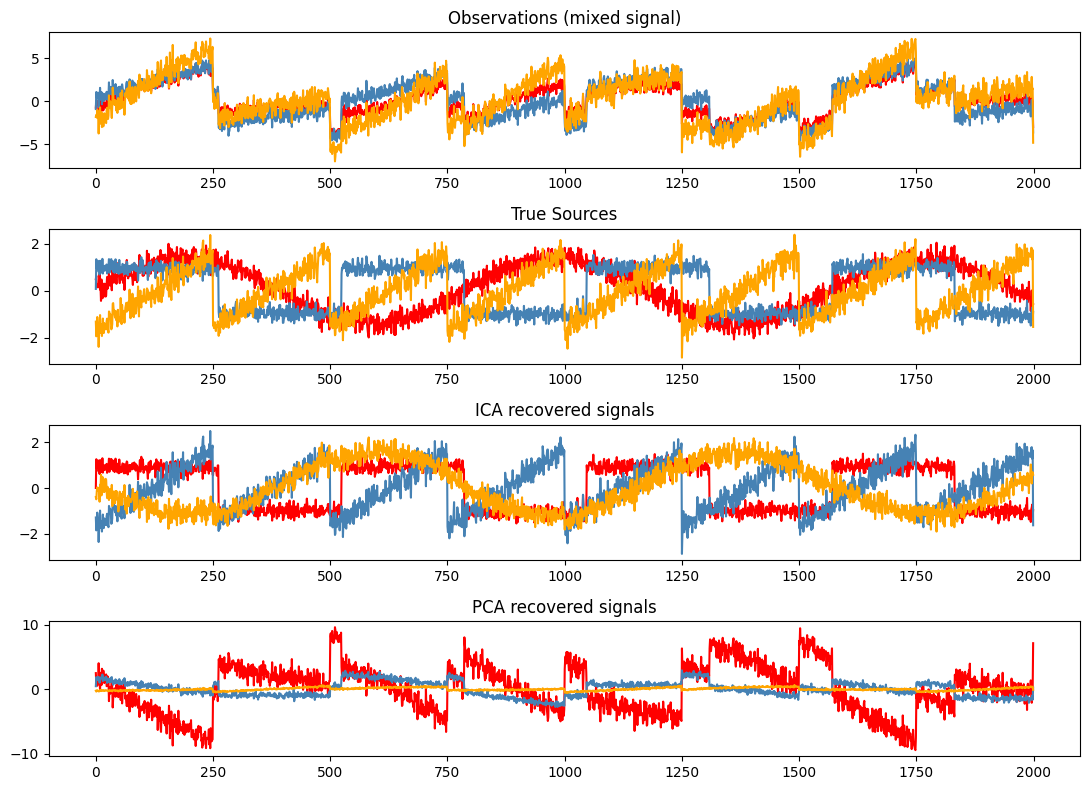

In [62]:
plt.figure(figsize=(11,8))
models = [X, S, S_, H]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA recovered signals', 
         'PCA recovered signals']
colors = ['red', 'steelblue', 'orange']
for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)
plt.tight_layout()
plt.show()

## Other Techniques


1. Random Projections
https://scikit-learn.org/stable/modules/random_projection.html
2. Multidimensional Scaling
3. Isomap
4. t-Distributed stochastic neighbor embedding
5. Linear discriminant analysis